In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import warnings
import keras
from keras import models
from keras.models import Sequential
from keras import layers
from keras.layers import Embedding, Bidirectional, Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Reshape, TimeDistributed
from keras import optimizers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn import metrics
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
df=pd.read_json(r"./../../Dataset/Sarcasm_Headlines_Dataset_v2/Sarcasm_Headlines_Dataset_v2.json",lines=True)

In [3]:
df.shape

(28619, 3)

In [4]:
df.columns

Index(['is_sarcastic', 'headline', 'article_link'], dtype='object')

In [5]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


## Load BERT Embeddings

The BERT Embeddings were created and stored in an NPY file for faster and efficient use.

The benefit of doing so is that we do not have to run the BERT moidel every time we want to run a classification model. This saves time and resources as it runs on GPU and requires a lot of RAM.

In [6]:
# Load BERT embedding numpy array from npy file
from numpy import load
embeddings_npy = load('embeddings.npy')
# print the array
print(embeddings_npy)

[[-0.08782839  0.06258331 -0.12000587 ... -0.33156553  0.5002954
   0.1805836 ]
 [-0.43426287 -0.50481713 -0.36135322 ... -0.02944355  0.34979802
   0.26927984]
 [-0.13752083 -0.09303751  0.14121507 ... -0.0079867   0.26747227
   0.29764438]
 ...
 [-0.28889391 -0.20626098  0.15944281 ... -0.02881556  0.36084583
   0.32674789]
 [-0.66664398 -0.10732649 -0.48685697 ... -0.26801217  0.5380348
   0.31238717]
 [-0.05215537  0.08621484  0.14538945 ... -0.13530289  0.40199804
   0.26933154]]


In [7]:
embeddings_npy.shape

(28619, 768)

## Creating Test Training Split

In [8]:
labels = df['is_sarcastic']

In [9]:
train_features, test_features, train_labels, test_labels = train_test_split(embeddings_npy, labels)

In [10]:
#training and test data splits
x_train, x_test, y_train, y_test = train_test_split(embeddings_npy, labels, test_size = 0.25, random_state = 0)

In [11]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(21464, 768)
(7155, 768)
(21464,)
(7155,)


# Classification Task

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.decomposition import TruncatedSVD

## Naive Bayes classifier

In [13]:
#Naive Bayes classifier
def test_NaiveBayes(x_train, x_test, y_train, y_test):
    MNB = GaussianNB()
    NBClassifier = MNB.fit(x_train, y_train)
    predictions = NBClassifier.predict(x_test)
    a = accuracy_score(y_test, predictions)
    p = precision_score(y_test, predictions, average = 'weighted')
    r = recall_score(y_test, predictions, average = 'weighted')
    f = f1_score(y_test, predictions, average = 'weighted')
    return a, p, r, f

In [14]:
%%time
#Tesiting Naive-Bayes classifier
accuracy, precision, recall, f1 = test_NaiveBayes(x_train, x_test, y_train, y_test)
print("Accuracy =",accuracy)
print("Precision=",precision)
print("Recall   =",recall)
print("F1 Score =",f1)

Accuracy = 0.7875611460517121
Precision= 0.787510487345231
Recall   = 0.7875611460517121
F1 Score = 0.7871587386094959
Wall time: 444 ms


## Logistic Regression classifier

In [15]:
from sklearn.linear_model import LogisticRegression
def test_LogisticRegression(x_train, x_test, y_train, y_test):
    model = LogisticRegression(class_weight='balanced',solver="liblinear",max_iter=300, C=1e7)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    a = accuracy_score(y_test, predictions)
    p = precision_score(y_test, predictions, average = 'weighted')
    r = recall_score(y_test, predictions, average = 'weighted')
    f = f1_score(y_test, predictions, average = 'weighted')
    return a, p, r, f

In [16]:
%%time
#Tesiting Logistic Regression classifier
accuracy, precision, recall, f1 = test_LogisticRegression(x_train, x_test, y_train, y_test)
print("Accuracy =",accuracy)
print("Precision=",precision)
print("Recall   =",recall)
print("F1 Score =",f1)

Accuracy = 0.8749126484975541
Precision= 0.8752604363196443
Recall   = 0.8749126484975541
F1 Score = 0.8749851035691031
Wall time: 22.2 s


## Multilayer Perceptron classfier

In [17]:
#Multilayer Perceptron classfier
def test_NN(x_train, x_test, y_train, y_test):
    NN = MLPClassifier(solver = 'adam', alpha = 0.00095, learning_rate = 'adaptive', learning_rate_init = 0.01, max_iter = 300, random_state = 0)
    Perceptron = NN.fit(x_train, y_train)
    predictions = Perceptron.predict(x_test)
    a = accuracy_score(y_test, predictions)
    p = precision_score(y_test, predictions, average = 'weighted')
    r = recall_score(y_test, predictions, average = 'weighted')
    f = f1_score(y_test, predictions, average = 'weighted')
    return a, p, r, f

In [18]:
%%time
#Testing NN classifier
accuracy, precision, recall, f1 = test_NN(x_train, x_test, y_train, y_test)
print("Accuracy =",accuracy)
print("Precision=",precision)
print("Recall   =",recall)
print("F1 Score =",f1)

Accuracy = 0.8774283717679944
Precision= 0.8788462858403692
Recall   = 0.8774283717679944
F1 Score = 0.8775508046844797
Wall time: 44.3 s


## SVM classifier

In [19]:
#SVM classifier
def test_SVM(x_train, x_test, y_train, y_test):
    SVM = SVC(kernel = 'linear')
    SVMClassifier = SVM.fit(x_train, y_train)
    predictions = SVMClassifier.predict(x_test)
    a = accuracy_score(y_test, predictions)
    p = precision_score(y_test, predictions, average = 'weighted')
    r = recall_score(y_test, predictions, average = 'weighted')
    f = f1_score(y_test, predictions, average = 'weighted')
    return a, p, r, f

In [20]:
%%time
#Testing SVM classifier
accuracy, precision, recall, f1 = test_SVM(x_train, x_test, y_train, y_test)
print("Accuracy =",accuracy)
print("Precision=",precision)
print("Recall   =",recall)
print("F1 Score =",f1)

Accuracy = 0.8770090845562544
Precision= 0.8770868432074758
Recall   = 0.8770090845562544
F1 Score = 0.8770363570336226
Wall time: 7min 22s


## Extreme Learning Machine (ELM)

In [21]:
%%time
input_size = x_train.shape[1]
hidden_size = 1000
input_weights = np.random.uniform(low=0, high=1,size=[input_size,hidden_size])
biases = np.random.uniform(low=0, high=1,size=[hidden_size])

def relu(x):
    return np.maximum(x, 0, x)

def hidden_nodes(X):
    G = np.dot(X, input_weights)
    G = G + biases
    H = relu(G)
    return H

output_weights = np.dot(np.linalg.pinv(hidden_nodes(x_train)), y_train)

def predict(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights)
    return out

prediction = predict(x_test)

y_pred=[1/(1+np.exp(-x)) for x in prediction]

Wall time: 5.58 s


In [22]:
acc=[]
prec=[]
rec=[]
for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]:
    y_pred=[1 if x>=i else 0 for x in prediction]
    acc.append(metrics.accuracy_score(y_test, y_pred))
    prec.append(metrics.precision_score(y_test, y_pred))
    rec.append(metrics.recall_score(y_test, y_pred))

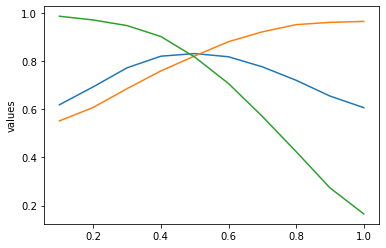

In [23]:
plt.plot(np.arange(0.1,1.1,0.1),acc)
plt.plot(np.arange(0.1,1.1,0.1),prec)
plt.plot(np.arange(0.1,1.1,0.1),rec)
plt.ylabel('values')
plt.show()

In [24]:
y_pred=[1 if x>=0.5 else 0 for x in prediction]

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

# Model F1-Score
print("F1-Score:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.8314465408805032
Precision: 0.8215680384499849
Recall: 0.8171496862862264
F1-Score: 0.8193529059316956
